<a href="https://colab.research.google.com/github/nghess/makemore/blob/main/makemore_lesson3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [369]:
import numpy as np
import urllib3
import random 
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Import text file

In [370]:
# Grab text file from github
http = urllib3.PoolManager()
textfile = http.request('GET', 'https://raw.githubusercontent.com/nghess/makemore/master/names.txt')
words = str(textfile.data, 'utf-8').splitlines()

In [371]:
# Take a peak at text file
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [372]:
# Build character to/from string mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
block_size = 3  # context length: how many characters do we use to predict the next one?

In [373]:
# Build the dataset
def build_dataset(words):

  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] #  Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [374]:
n_emb = 10
n_hidden = 100
n_chars = len(stoi)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((n_chars, n_emb), generator=g)
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3)/((n_emb*block_size)**0.5)  # Kaiming init
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, n_chars), generator=g) * 0.01
b2 = torch.randn(n_chars, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
  p.requires_grad = True

In [375]:
# PyTorchify the network

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
        self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)  # Batch mean
      xvar = x.var(0, keepdim=True, unbiased=True)  # Batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x- xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # Update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [376]:
# Hyperparams
n_embd = 10  # Dimensions for character embedding vector
n_hidden = 100  # Number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)

# Network architecture
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
  ]

# Initializing layers with gain/attenuation
with torch.no_grad():
  # Last layer: make less confident
  layers[-1].gamma *= 0.1  # Batchnorm layers get .gamma rather than .weight
  #layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5. #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
# Initialize graph for parameter backprop
for p in parameters:
  p.requires_grad = True

47024


In [377]:
iters = 100000
batch_size = 32
lossi = []
ud = []


# Forward pass
for i in range(iters):

  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]  # Batch x, y

  # Forward pass
  emb = C[Xb]  # (32, 2, 2) by indexing into the dataset 
  x = emb.view(emb.shape[0], -1)  # Concatenate the vectors
  # Linear layer
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)
  
  # Backward pass
  for layer in layers:
    layer.out.retain_grad()  # After debug: would take out retain.grad
  for p in parameters:
      p.grad = None
  loss.backward()

  # Update
  lr = .1 if i < int(iters/2) else 0.1 
  for p in parameters:
    p.data += -lr * p.grad

  # Track loss
  if i % 10000 == 0: # print every 10000 iters
    print(f'{i:7d}/{iters:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:  # For quick preview
  #  break

      0/ 100000: 3.2870
  10000/ 100000: 2.5076
  20000/ 100000: 2.1270
  30000/ 100000: 2.1271
  40000/ 100000: 2.2030
  50000/ 100000: 2.2949
  60000/ 100000: 1.7192
  70000/ 100000: 2.2756
  80000/ 100000: 2.5162
  90000/ 100000: 2.0769


layer 2 (      Tanh): mean +0.04, std 0.62, saturated: 7.50%
layer 5 (      Tanh): mean -0.02, std 0.66, saturated: 10.00%
layer 8 (      Tanh): mean -0.01, std 0.69, saturated: 9.62%
layer 11 (      Tanh): mean -0.02, std 0.71, saturated: 8.41%
layer 14 (      Tanh): mean -0.03, std 0.74, saturated: 10.56%


Text(0.5, 1.0, 'activation distribution')

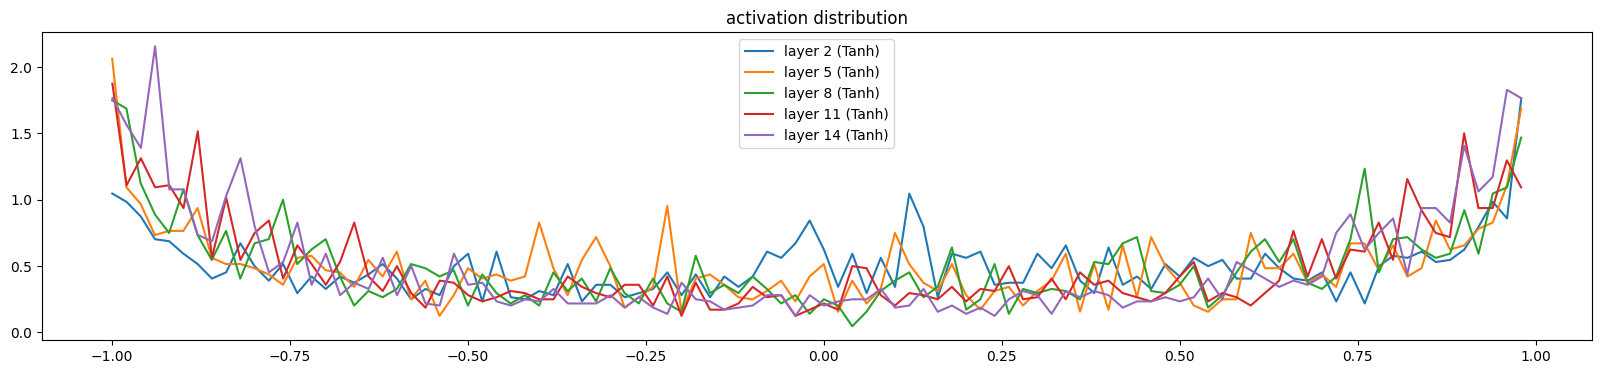

In [378]:
# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):  # Exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 6.311851e-03
layer 5 (      Tanh): mean +0.000000, std 5.100557e-03
layer 8 (      Tanh): mean -0.000000, std 5.017770e-03
layer 11 (      Tanh): mean +0.000000, std 4.930856e-03
layer 14 (      Tanh): mean -0.000000, std 5.025994e-03


Text(0.5, 1.0, 'gradient distribution')

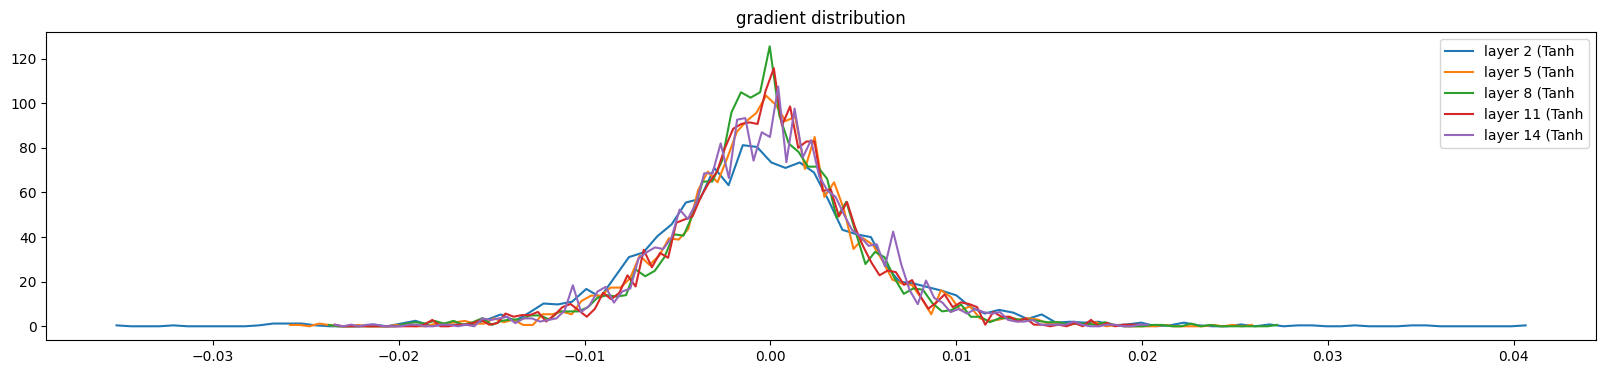

In [379]:
# Visualize histograms
plt.figure(figsize=(20, 4))  # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # Exclude the output layer.
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.874812e-02 | grad:data ratio 1.712800e-02
weight  (30, 100) | mean -0.000032 | std 5.088267e-03 | grad:data ratio 5.380309e-03
weight (100, 100) | mean -0.000016 | std 4.149786e-03 | grad:data ratio 8.094283e-03
weight (100, 100) | mean +0.000012 | std 3.794686e-03 | grad:data ratio 7.358227e-03
weight (100, 100) | mean +0.000023 | std 3.706479e-03 | grad:data ratio 7.231466e-03
weight (100, 100) | mean +0.000017 | std 3.224390e-03 | grad:data ratio 6.299763e-03
weight  (100, 27) | mean +0.000097 | std 6.550596e-03 | grad:data ratio 1.234837e-02


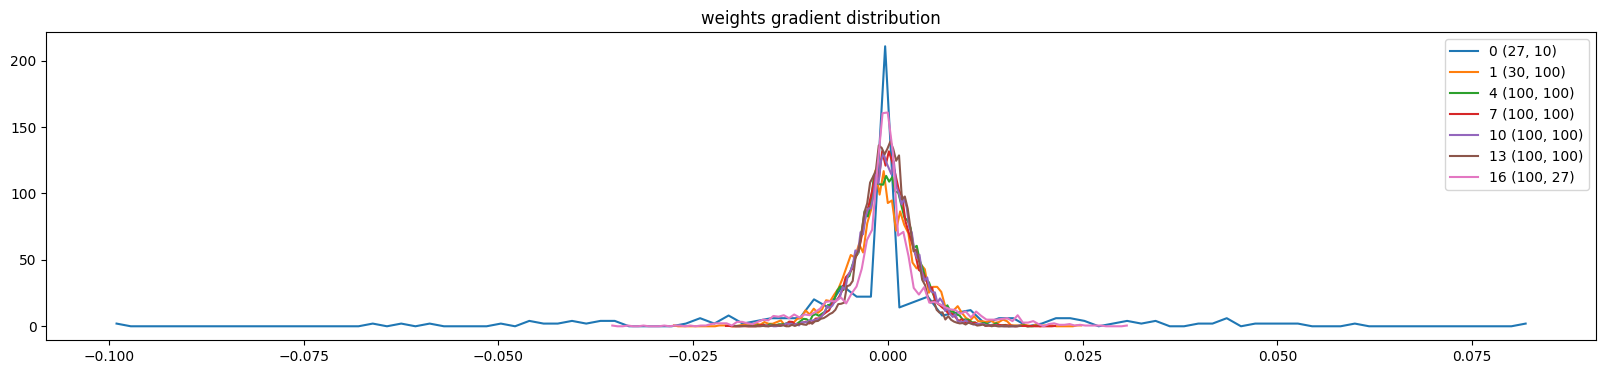

In [380]:
# Visualize histograms
plt.figure(figsize=(20, 4))  # Width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

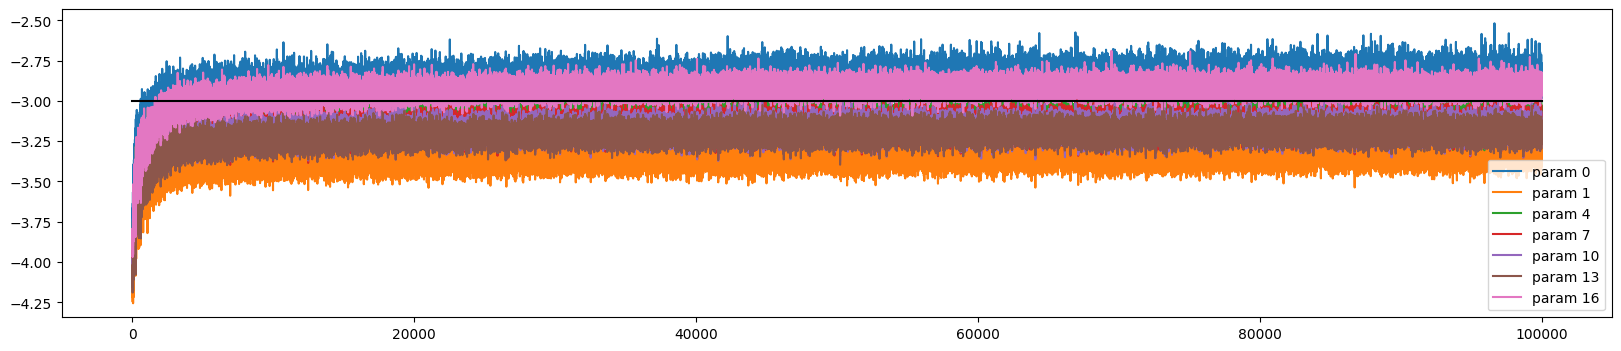

In [381]:
# Visualize gradient to data ratio
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [382]:
# Evaluate performance
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0915184020996094
val 2.134155750274658


In [387]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(50):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out[:-1])) # decode and print the generated word

carlah
americk
fismrix
thiyah
cassie
rahnen
delynn
jareei
nellara
chaiir
kaleigh
ham
pory
quint
shon
rai
addi
waler
giaaryxi
fine
pirra
med
edi
abette
hasti
alaas
braj
ksyn
pamborozelynn
nai
kaseren
kalla
luco
zoessi
ora
krynie
monleynr
adexon
loub
ruvi
daya
kenziah
brichloer
ranislyn
kendeyah
ninadak
kases
anikoamlten
bry
adylon
